In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.callbacks import ModelCheckpoint

In [60]:
N_int = 25
Amplituda = 1.
N_target = 1000
d = 0.7
k = 2 * math.pi
MAX = 2.

In [61]:
def gen_signal(NUM, space):
    signal = []
    for i in range(-NUM, NUM):
        if i == -space or i == space:
            signal.append(MAX)
        else:
            signal.append(0.02)
    return signal

In [62]:
NUM = N_int * 2
space = 15
signal = gen_signal(NUM, space)

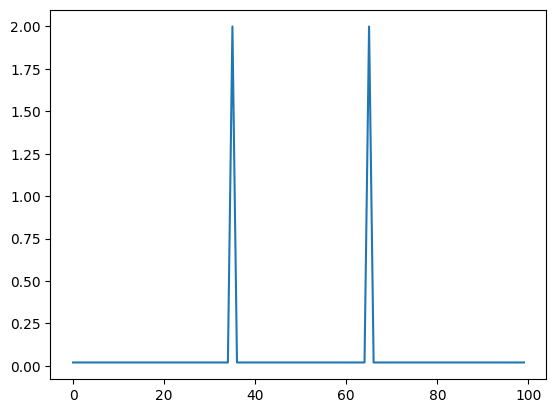

In [63]:
plt.plot(signal)

In [64]:
#Defining Function to add random noise (Ornstein-Uhlenbeck_process) in actions to increase Exploration
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [65]:
def GetCn(k, d, N=N_int, alp1=0.01*MAX):
    Cn = []
    for n in range(N):
        Cn.append(2 * math.cos(k * d * n * alp1))
    return Cn

def GetCnNoised(k, d, N=N_int, alp1=0.015, std_dev=0.15):
    Cn = []
    ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    for i in range(N):
        noise = ou_noise()
        Cn.append(2 * math.cos(k * d * i * alp1) + noise)
    return Cn

def CopySignal(Cn):
    Cn_copy = []
    for i in range(len(Cn)):
        Cn_copy.append(Cn[i])
    return Cn_copy

In [66]:
# alp1 = 0.01*MAX
alp1 = 0.005
Cn_25 = GetCn(k, d, N=N_int, alp1=alp1)
Cn_target = GetCn(k, d, N=N_target, alp1=alp1)
Cn_25_N = GetCnNoised(k, d, N=N_int, alp1=alp1, std_dev=0.02*MAX)
Cn_target_N = GetCnNoised(k, d, N=N_target, alp1=alp1, std_dev=0.*MAX)

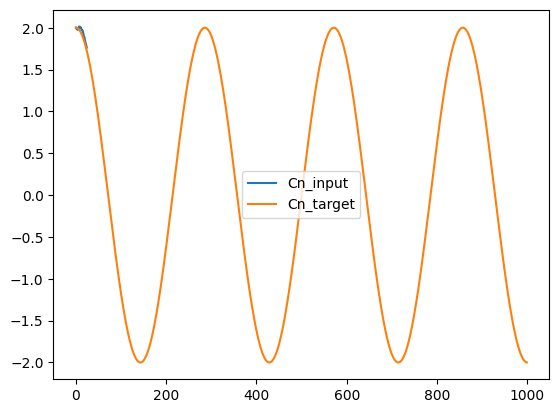

In [67]:
# plt.plot(Cn_25, label='Cn_input')
plt.plot(Cn_25_N, label='Cn_input')
plt.plot(Cn_target, label='Cn_target')
# plt.plot(Cn_target_N, label='Cn_target_N')
plt.legend()

In [47]:
CnFull = np.concatenate((Cn_25[::-1], Cn_25))

In [48]:
# plt.plot(CnFull)

In [73]:
def GetF(k, d, alfa, alf=alp1, N=N_int):
    F = 0
    for n in range(N):
        F += 2*math.cos(k * d * n * (alf - alfa))
    return F

def GetI(k, d, alpha, alf=alp1, Amplituda=Amplituda, N=N_int):
    I_alp = []
    sum = 0
    for alph in alpha:
        sum += Amplituda * GetF(k, d, alph, alf=alp1, N=N_int) + Amplituda * GetF(k, d, alph, alf=-alp1, N=N_int)
        I_alp.append(sum)
    return np.array(I_alp)

In [74]:
def GetAllF(k, d, alpha, alf1=0.1, N=N_int):
    I_alpha = GetI(k, d, alpha, alf=alf1, N=N_int)
    IFull = np.concatenate((I_alpha[::-1], I_alpha))
    
    F_getted1 = []
    for alpha_i in alpha:
        F_getted1.append(GetF(k, d, alpha_i, alf=alf1, N=N_int))

    F_getted2 = []
    for alpha_i in alpha:
        F_getted2.append(GetF(k, d, alpha_i, alf=-alf1, N=N_int))

    return np.array(F_getted1) + np.array(F_getted2)

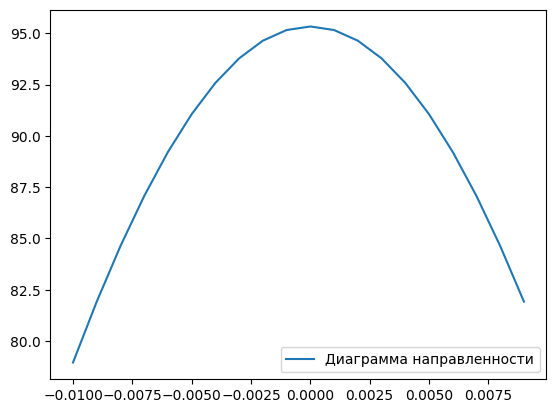

In [75]:
alphaF = np.arange(-0.01, 0.01, 0.001)
plt.plot(alphaF, GetAllF(k, d, alphaF, alf1=0.005, N=N_int), label='Диаграмма направленности')
plt.legend()

In [76]:
def GetU_Cn(k, d, alpha, Cn, N=N_int):
    Full_U = []
    for alp in alpha:
        sum = 0
        for n in range(N):
            sum += Cn[n] * 2 * math.cos(k * d * n * alp)
        Full_U.append(sum)
    return np.array(Full_U)

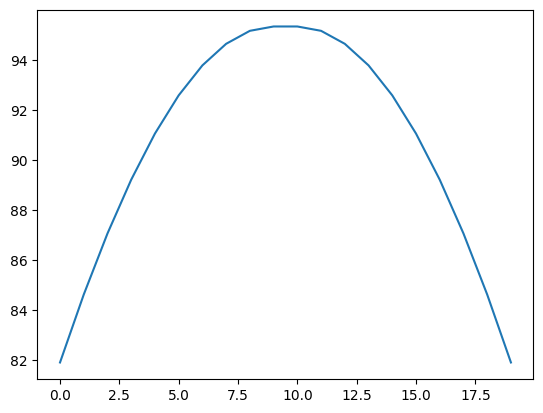

In [77]:
# принятый сигнал цифровой антенной решеткой
alphaU = np.arange(0., 0.01, 0.001)
# CnFull = np.concatenate((Cn_25[::-1], Cn_25))
U_Cn = GetU_Cn(k, d, alphaU, Cn_25, N=N_int)
U_Full = np.concatenate((U_Cn[::-1], U_Cn))
plt.plot(U_Full)

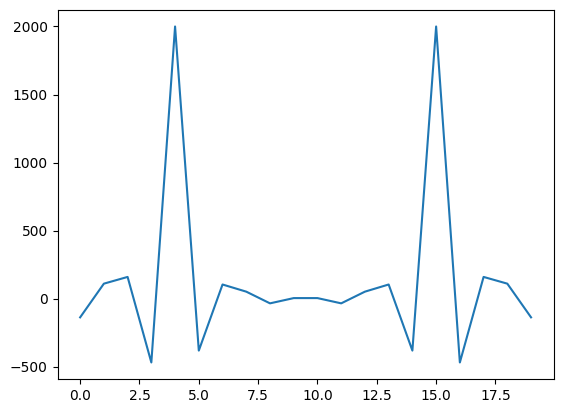

In [78]:
U_Cn = GetU_Cn(k, d, alphaU, Cn_target, N=N_target)
U_Full = np.concatenate((U_Cn[::-1], U_Cn))
plt.plot(U_Full)

In [79]:
def create_data(N_int, N_target, num=200000, noised=False, std_dev=0.01):
    x_data = []
    y_data = []
    if noised == False:
        for i in range(num):
            alp1 = random.uniform(0.0001, 0.03)
            # alp1 = 0.005
            Cn_25 = GetCn(k, d, N=N_int, alp1=alp1)
            Cn_25.append(alp1)
            x_data.append(Cn_25)
            Cn_target = GetCn(k, d, N=N_target, alp1=alp1)
            y_data.append(Cn_target)
    else:
        for i in range(num):
            alp1 = random.uniform(0.0001, 0.03)
            # alp1 = 0.005
            Cn_25 = GetCnNoised(k, d, N=N_int, alp1=alp1, std_dev=std_dev)
            Cn_25.append(alp1)
            x_data.append(Cn_25)
            Cn_target = GetCn(k, d, N=N_target, alp1=alp1)
            y_data.append(Cn_target)
    return np.array(x_data, dtype=object).astype('float32'), np.array(y_data, dtype=object).astype('float32')

In [80]:
x_data, y_data = create_data(N_int, N_target, noised=True, std_dev=0.01)
x_val, y_val = create_data(N_int, N_target, num=15000, noised=True, std_dev=0.01)

In [88]:
weights_file = '../weights/weights_nn.h5'
# callback = ModelCheckpoint(weights_file, mode='max', save_best_only=True)

# scheduler for learning rate
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

callbacks = [
    keras.callbacks.ModelCheckpoint(
        weights_file, mode='max', save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.LearningRateScheduler(scheduler),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

batch_size = 128
epochs = 35

model = Sequential()
model.add(layers.Dense(x_data.shape[-1], activation='selu'))
model.add(layers.Dense(128, activation='selu'))
model.add(layers.Dense(512, activation='selu'))
model.add(layers.Dense(256, activation='selu'))
# model.add(layers.Dense(256, activation='selu'))
model.add(layers.Dense(y_data.shape[-1]))

model.compile(optimizer='adam', loss=tf.losses.Huber(2.15), metrics=['accuracy'])

model.build(input_shape=(None, x_data.shape[-1]))
# model.load_weights(weights_file)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 26)                702       
                                                                 
 dense_21 (Dense)            (None, 128)               3456      
                                                                 
 dense_22 (Dense)            (None, 512)               66048     
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 1000)              257000    
                                                                 
Total params: 458,534
Trainable params: 458,534
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(x_data, y_data,
            validation_data=(x_val, y_val),
            epochs=epochs, batch_size=batch_size,
            callbacks=callbacks)

Epoch 1/35
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6149 - accuracy: 0.0548 - val_loss: 0.3952 - val_accuracy: 0.1841 - lr: 0.0010
Epoch 2/35
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3099 - accuracy: 0.0230 - val_loss: 0.2342 - val_accuracy: 0.0271 - lr: 0.0010
Epoch 3/35
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2103 - accuracy: 0.0202 - val_loss: 0.2018 - val_accuracy: 0.0024 - lr: 0.0010
Epoch 4/35
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1686 - accuracy: 0.0199 - val_loss: 0.1695 - val_accuracy: 0.0032 - lr: 0.0010
Epoch 5/35
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1490 - accuracy: 0.0173 - val_loss: 0.1402 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/35
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1399 - accuracy: 0.0151 - val_loss: 0.1405 - val_accuracy: 0.0054 - lr: 0.0010
Epoch 7/35
1563/1563 [==========================

In [90]:
model = keras.models.load_model(weights_file)

x_test, y_test = create_data(N_int, N_target, num=10000, noised=True)
model.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.1845


[0.3960552513599396, 0.18449999392032623]

In [91]:
x_test, y_test = create_data(N_int, N_target, num=10000, noised=False)
model.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 0s 3ms/step - loss: 0.3874 - accuracy: 0.2356


[0.38741934299468994, 0.23559999465942383]

In [92]:
std_dev = 0.01
alp1 = 0.005

Cn_25 = GetCnNoised(k, d, N=N_int, alp1=alp1, std_dev=std_dev)
Cn_25_clear = GetCn(k, d, N=N_int, alp1=alp1)
Cn_25_copy = CopySignal(Cn_25)
Cn_25.append(alp1)
Cn_25 = np.array(Cn_25, dtype='object').astype('float32')
Cn_25 = Cn_25.reshape(1, len(Cn_25))
Cn_target = GetCn(k, d, N=N_target, alp1=alp1)

In [93]:
predict = model.predict(Cn_25)

1/1 [==============================] - 0s 27ms/step


In [94]:
Cn_predict = predict.reshape(N_target,)

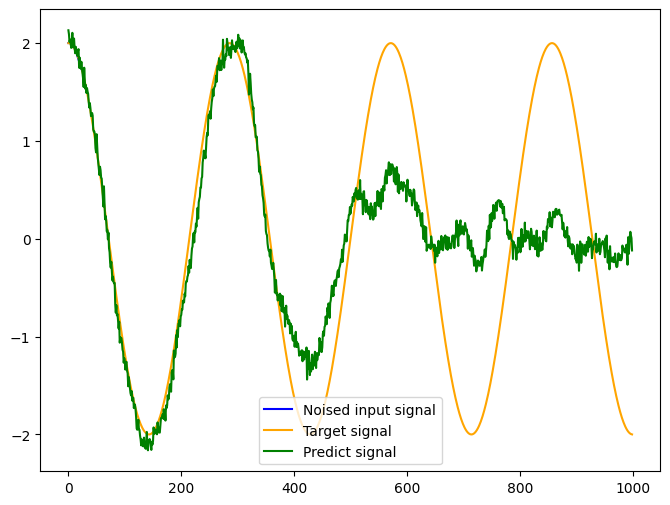

In [95]:
# plt.plot(predict)
# Cn_25 = GetCnNoised(k, d, N=25, alp1=alp1)
# plt.plot(Cn_25_copy)
# plt.plot(Cn_35)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Cn_25_copy, 'blue', label='Noised input signal')
ax.plot(Cn_target, 'orange', label='Target signal')
ax.plot(Cn_predict, 'green', label='Predict signal')
plt.legend()
plt.show()

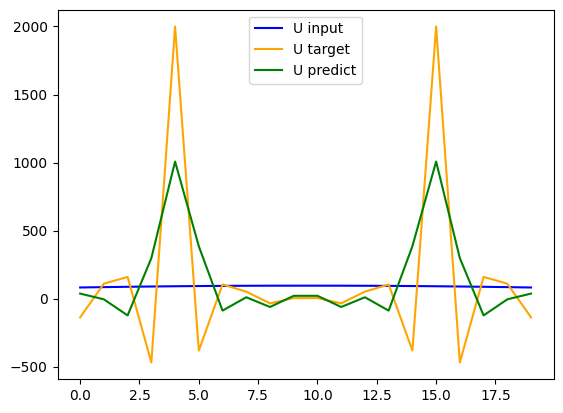

In [96]:
alphaU = np.arange(0., 0.01, 0.001)
# CnFull = np.concatenate((Cn_25[::-1], Cn_25))
U_getted = GetU_Cn(k, d, alphaU, Cn_25_copy, N=N_int)
U_predict = GetU_Cn(k, d, alphaU, Cn_predict, N=N_target)
U_target = GetU_Cn(k, d, alphaU, Cn_target, N=N_target)
U_Full_getted = np.concatenate((U_getted[::-1], U_getted))
U_Full_predict = np.concatenate((U_predict[::-1], U_predict))
U_Full_target = np.concatenate((U_target[::-1], U_target))
plt.plot(U_Full_getted, 'blue', label='U input')
plt.plot(U_Full_target, 'orange', label='U target')
plt.plot(U_Full_predict, 'green', label='U predict')
plt.legend()